# Multilayer perceptron

Pytorch framework documentation [here](https://pytorch.org/)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# import time
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn

## Load data - [MNIST](http://yann.lecun.com/exdb/mnist/)

In [7]:
# Load MNIST data
train_data = pd.read_csv( '/content/sample_data/mnist_train_small.csv' , header=None)
test_data = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)

print(train_data.shape )
X_train = np.array(train_data.iloc[:,1:])
y_train = np.array(train_data.iloc[:,0])

X_test = np.array(test_data.iloc[:,1:])
y_test = np.array(test_data.iloc[:,0])

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(20000, 785)
(20000, 784) (20000,)
(10000, 784) (10000,)


In [ ]:
# create train / test splits
# X_train, X_test, y_train, y_test = _

# Reshape to bidimensional (image) size
X_train, X_test = _ , _

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16000, 28, 28) (4000, 28, 28) (16000,) (4000,)


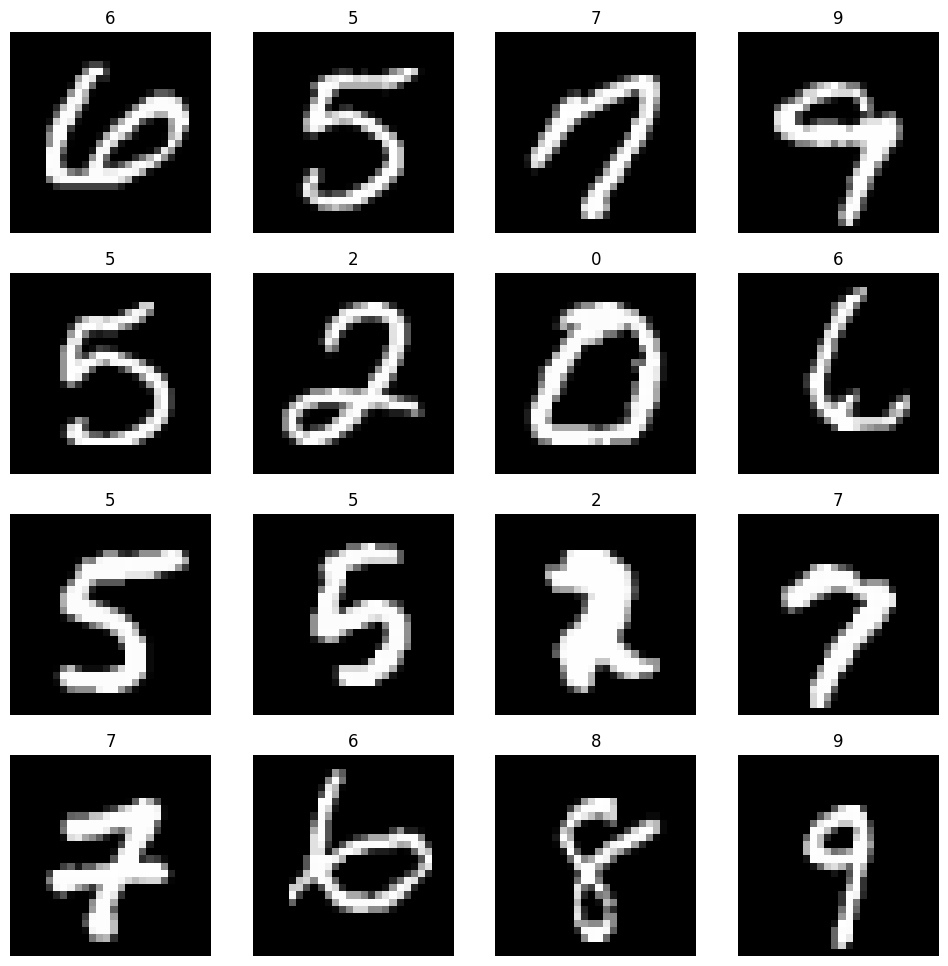

In [8]:
# Visualize grid of samples
grid_size = (4,4)

_, axes = plt.subplots ( grid_size[0] , grid_size[1] , figsize=(3*grid_size[0],3*grid_size[1]))
axes = axes.ravel()

for i, ax in enumerate(axes):
  ax.imshow( X_train[i].reshape([28,28]) , cmap='gray')
  ax.set_axis_off()
  ax.set_title('{0}'.format(y_train[i]))


In [10]:
# Reshape the data - MLPs do not understand such '2D' stuff
# Reshape to 1D is similat to "flatten" an image

# Configuration options
feature_vector_length = 784
num_classes = 10

print(X_train.max(), X_train.min(), X_test.max(), X_test.min())
# Convert into 0 - 1 values
X_train = X_train / X_train.max()
X_test =  X_test / X_test.max()

print(X_train.max(), X_train.min(), X_test.max(), X_test.min())

1.0 0.0 1.0 0.0
1.0 0.0 1.0 0.0


In [ ]:
#Lo de arriba se corre dos veces
#lo de abajo solo una vez

In [11]:
# Convert target classes to categorical ones - one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [13]:
print(y_train.shape,y_test.shape)

(20000, 10) (10000, 10)


## Create a graph model

In [14]:
from torchsummary import summary

model = torch.nn.Sequential(
    nn.Linear( feature_vector_length , 768 ), nn.ReLU(), #capa de entrada o input
    nn.Linear( 768 , 512 ), nn.ReLU(), #
    nn.Linear( 512 , 256 ), nn.ReLU(), #
    nn.Linear( 256 , 128 ), nn.ReLU(), #estas intermedias, se llaman capas ocultas o hidden layers
    nn.Linear( 128 , 64 ), nn.ReLU(),  #
    nn.Linear( 64 , 32 ), nn.ReLU(),   #
    nn.Linear( 32 , num_classes ), nn.Softmax() #capa de salida u output
)

summary(model, input_size=(784,), device=('cpu'))



#recomendación1: Iniciar ingresando el valor inicial y el valor final, que son lo que no se pueden modificar
#recomendacion2: el numero de perceptrones no debe ser muy abrupto con base en el numero de entradas (ni por mas ni por menos)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 768]         602,880
              ReLU-2                  [-1, 768]               0
            Linear-3                  [-1, 512]         393,728
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 128]          32,896
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 32]           2,080
             ReLU-12                   [-1, 32]               0
           Linear-13                   [-1, 10]             330
          Softmax-14                   

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1844: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


## Define loss function and optimizer

In [15]:
loss = nn.CrossEntropyLoss() #esta se usa lsolo para problemas de clasificacion de resto se usa: nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

## Train model

In [ ]:
# Model params for training
epochs = 100
batch_size = 200 # We dont train the whole dataset at the time
losses = []

progress = tqdm(range(epochs), ncols=110)

for epoch in progress: # Iterate over all the num of epochs
  #
  batch_losses = 0

  for idx in range(0, len(X_train), batch_size) : # Iterate over all batches of data
    #
    # First step, take the data from the dataset
    batch_X = X_train[idx: idx + batch_size]
    batch_y = y_train[idx: idx + batch_size]
    batch_X = torch.from_numpy(batch_X).to(torch.float32) # Convert to torch tensor to feed the graph
    batch_y = torch.from_numpy(batch_y).to(torch.float32) # Convert to torch tensor to feed the graph

    # 1.Zero the gradients
    optimizer.zero_grad()

    # 2.Perform forward pass
    predictions = model(batch_X)

    # 3.Compute loss
    batch_loss = loss(predictions, batch_y)

    # 4.Perform backward pass
    batch_loss.backward()

    # 5.Optimize parameters
    optimizer.step()

    ## Accumulate loss to compute mean over all batches
    batch_losses += batch_loss.item()

  # Compute time and show all progress
  progress.set_description("[Epoch %d/%d] [Loss: %f]" % (epoch, epochs,
                                                         (batch_losses / len(X_train)/batch_size)))

  # Save epoch loss
  losses.append(batch_losses/(len(X_train)/batch_size))


## Plot results

In [ ]:
# Plot progress (loss function)

## Compute metrics over ```X_test``` images

In [ ]:
progress = tqdm(range( _ , _ , _ ), ncols=100)
predictions = _

for _ : # Iterate over all batches of data
  #
  batch_X = _
  batch_y = _

  # Perform forward pass to compute predictions
  batch_predictions = _
  _  = _

y_test_ = np.argmax(y_test, axis=1)
acc = _
cm_ = _

# Compute confusion matrix and accuracy
_, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_, cmap="hot", annot=True, ax=ax)
print("acc: {0}".format(acc))